(75, 75, 3)


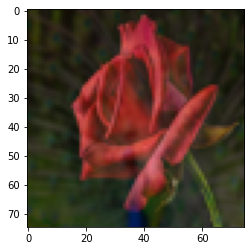

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy

# img = Image.open('train2.jpg')
img = Image.open('flower.png')
img = img.resize((75, 75))
# plt.imshow(img)
img = np.array(img)
img = img[:, :, ::-1]
print(img.shape)
plt.imshow(Image.fromarray(img))

In [ ]:
def grad(img):
    # only for single channel (pass each channel of RGB image separately)
    assert(len(img.shape) == 2)

    img_col = np.zeros_like(img)
    # shifting columns of img to the right by one unit
    img_col[:, :img.shape[1] - 1] = img[:, 1:]
    # last column is repeated
    img_col[:, img.shape[1] - 1] = img[:, -1]

    img_row = np.zeros_like(img)
    # shifting rows of img down by one unit
    img_row[:img.shape[0] - 1, :] = img[1:, :]
    # last row is repeated
    img_row[img.shape[0] - 1, :] = img[-1, :]

    # gradient in x and y
    grad_img = np.zeros((img.shape[0], img.shape[1], 2))
    grad_img[:, :, 0] = img_col - img
    grad_img[:, :, 1] = img_row - img

    return grad_img

def div(grad_img):
    # for 2 channel gradient inputs
    m, n, _ = grad_img.shape

    div_img = np.zeros((m, n))

    T = grad_img[:, :, 0]
    T1 = np.zeros_like(div_img)
    T1[:, 1:] = T[:, :(n-1)]

    div_img += (T - T1)

    T = grad_img[:, :, 1]
    T1 = np.zeros_like(div_img)
    T1[1:, :] = T[:(m-1), :]

    div_img += (T - T1)

    return div_img

In [ ]:
# L(.) operator is equivalent to div(grad(.))

def div_thresh_grad(Y, thresh):
    grad_Y_curr = grad(Y)
    grad_norm_curr = np.linalg.norm(grad_Y_curr, axis=2)

    grad_norm_thresh_curr = grad_norm_curr.copy()
    grad_norm_thresh_curr[grad_norm_curr < thresh] = 0

    zero_ind = (grad_norm_thresh_curr == 0)
    grad_Y_curr[:, :, 0][zero_ind] = 0
    grad_Y_curr[:, :, 1][zero_ind] = 0

    return div(grad_Y_curr)


def grad_T(T, Y, thresh, eps, precomputed=None):
    m, n, ch_dim = Y.shape
    gradient_T = np.zeros_like(T)
    for ch_idx in range(ch_dim):
        L_T_curr = div(grad(T[:, :, ch_idx]))
        if precomputed is not None:
            div_dh_gradY_curr = precomputed[:, :, ch_idx]
        else:
            div_dh_gradY_curr = div_thresh_grad(Y[:, :, ch_idx], thresh)

        Lsq_term = div(grad(L_T_curr - div_dh_gradY_curr))

        gradient_T[:, :, ch_idx] = Lsq_term + (eps * (T[:, :, ch_idx] - Y[:, :, ch_idx]))

    return gradient_T

def objective_fn(T, Y, thresh, eps, A, f_i, lambda_reg, precomputed=None):
    m, n, ch_dim = Y.shape
    obj_term1 = np.zeros_like(Y)
    obj_val3 = 0
    for ch_idx in range(ch_dim):
        L_T_curr = div(grad(T[:, :, ch_idx]))
        if precomputed is not None:
            div_dh_gradY_curr = precomputed[:, :, ch_idx]
        else:
            div_dh_gradY_curr = div_thresh_grad(Y[:, :, ch_idx], thresh)
        obj_term1[:, :, ch_idx] = L_T_curr - div_dh_gradY_curr

        for filter_idx in range(f_i.shape[0]):
            convolved_op = scipy.signal.convolve(T[:, :, ch_idx], f_i[filter_idx], 'same')
            obj_term3 = np.multiply(A[:, :, ch_idx], convolved_op)
            obj_val3 += np.sum(np.abs(obj_term3))

    obj_val1 = 0.5 * np.linalg.norm(obj_term1) ** 2
    obj_val2 = (eps / 2) * (np.linalg.norm(T - Y) ** 2)
    obj_val3 *= lambda_reg
    return obj_val1 + obj_val2 + obj_val3

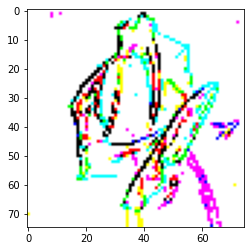

In [ ]:
# Define the 1D tensors
h1 = np.array([1, 2, 1])
h2 = np.array([1, 0, -1])
h3 = np.array([-1, 2, -1])

# Compute the tensor product of each pair of 1D tensors
f_i = np.array([np.outer(hi, hj) for hi in [h1, h2, h3] for hj in [h1, h2, h3]])

# print(H.shape) # (9, 3, 3)

def regularizer_A_mat(img, f_i, thresh):
    m, n, ch_dim = img.shape
    A_mat = np.zeros_like(img)
    for ch_idx in range(ch_dim):
        grad_img = grad(img[:, :, ch_idx])
        grad_mag = np.linalg.norm(grad_img, axis=2)
        grad_mag_normalized = (grad_mag - np.min(grad_mag)) * 255 / (np.max(grad_mag) - np.min(grad_mag))
        A_mat[:, :, ch_idx] = (grad_mag_normalized < thresh).astype(np.float64)
    return A_mat

test_A_mat = regularizer_A_mat(img / 255, f_i, thresh=70)
plt.imshow(test_A_mat)

convolved_identity = np.zeros((f_i.shape[0], img.shape[0], img.shape[0]))
I_m_mat = np.eye(img.shape[0])
for filter_idx in range(f_i.shape[0]):
    convolved_identity[filter_idx] = scipy.signal.convolve(I_m_mat, f_i[filter_idx], 'same')

def regularizer_gradient_term(T, A, f_i, convolved_identity):
    gradient_term = 0
    for ch_idx in range(T.shape[-1]):
        for filter_idx in range(f_i.shape[0]):
            convolved_op = scipy.signal.convolve(T[:, :, ch_idx], f_i[filter_idx], 'same')
            first_term = np.multiply(A[:, :, ch_idx], convolved_op)
            first_term_sign = np.sign(first_term)
            second_term = np.multiply(A[:, :, ch_idx], convolved_identity[filter_idx])
            gradient_term += np.trace(first_term_sign.T @ second_term)
    return gradient_term


grad_test = regularizer_gradient_term(img / 255, test_A_mat, f_i, convolved_identity)
# print(grad_test)

In [ ]:
from tqdm import tqdm

# without momentum (i.e. momentum=1.0) works better
def run_gd_momentum():
    thresh=0.033
    eps = 1e-8
    thresh_reg = 70
    lamda_reg = 2e-9

    momentum = 1.0
    max_iters = 4 * 1000
    print_every = 1000
    img_norm = img / 255
    T_var = img_norm.copy()
    # step_size = 3e-2
    # T_var = img_norm.copy() + (1e-2 * np.random.randn(img.shape[0], img.shape[1], img.shape[2]))

    # precomputing
    div_dh_gradY = np.zeros_like(img_norm)
    for ch_idx in range(img_norm.shape[-1]):
        div_dh_gradY[:, :, ch_idx] = div_thresh_grad(img_norm[:, :, ch_idx], thresh)

    precomputed = div_dh_gradY.copy()

    # Define the 1D tensors
    h1 = np.array([1, 2, 1])
    h2 = np.array([1, 0, -1])
    h3 = np.array([-1, 2, -1])

    # Compute the tensor product of each pair of 1D tensors
    f_i = np.array([np.outer(hi, hj) for hi in [h1, h2, h3] for hj in [h1, h2, h3]])

    convolved_identity = np.zeros((f_i.shape[0], img.shape[0], img.shape[0]))
    I_m_mat = np.eye(img.shape[0])
    for filter_idx in range(f_i.shape[0]):
        convolved_identity[filter_idx] = scipy.signal.convolve(I_m_mat, f_i[filter_idx], 'same')

    reg_A_mat = regularizer_A_mat(img_norm, f_i, thresh=thresh_reg)

    step_size = 3e-2
    obj_val_init = objective_fn(T_var, img_norm, thresh, eps, reg_A_mat, f_i, lamda_reg, precomputed)
    obj_val_best = obj_val_init
    T_best = T_var.copy()
    gradient_T_prev = np.zeros_like(T_var)
    print('iter: %3d, cost: %.9f'%(0, obj_val_init))
    pbar = tqdm(range(max_iters))
    for iter_idx in pbar:
        gradient_T_curr = grad_T(T_var, img_norm, thresh, eps, precomputed)
        gradient_reg_curr = regularizer_gradient_term(T_var, reg_A_mat, f_i, convolved_identity)
        update_curr = ((1 - momentum) * gradient_T_prev) + (momentum * step_size * gradient_T_curr) + (momentum * lamda_reg * gradient_reg_curr)
        T_var -= update_curr
        T_var = np.clip(T_var, 0, 1)
        obj_val_curr = objective_fn(T_var, img_norm, thresh, eps, reg_A_mat, f_i, lamda_reg, precomputed)
        pbar.set_postfix({'cost': obj_val_curr})
        if (iter_idx + 1) % print_every == 0:
            print('iter: %3d, cost: %.9f'%(iter_idx+1, obj_val_curr))
        if obj_val_curr > obj_val_best:
            # reverse the update
            T_var += update_curr
            # reduce step size for next iteration
            step_size /= 10
            lamda_reg /= 10
            print('reducing step size')
        else:
            obj_val_best = obj_val_curr
            T_best = T_var.copy()
    return T_best

T_best = run_gd_momentum()

iter:   0, cost: 3.489660715


 25%|██▌       | 1003/4000 [00:39<02:58, 16.82it/s, cost=0.00226]

iter: 1000, cost: 0.002269278


 50%|█████     | 2002/4000 [01:18<01:12, 27.46it/s, cost=0.0012]

iter: 2000, cost: 0.001202062


 75%|███████▌  | 3006/4000 [01:56<00:33, 29.72it/s, cost=0.000852]

iter: 3000, cost: 0.000852959


100%|██████████| 4000/4000 [02:33<00:00, 26.09it/s, cost=0.000679]

iter: 4000, cost: 0.000678852


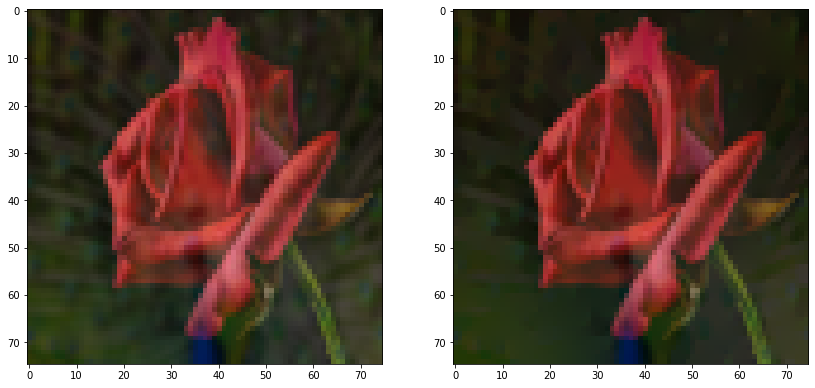

In [ ]:
T_img = Image.fromarray((T_best * 255).astype(np.uint8))

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1, 2, 1)
plt.imshow(Image.fromarray(img))

ax = plt.subplot(1, 2, 2)
plt.imshow(T_img)

In [ ]:
# Solving (mu * (L ** 2) - lam * L + eps) * u = k
def poisson_dct(eq, mu, lam, eps):
    m, n = eq.shape

    k_list = np.arange(1, m+1).reshape(-1, 1)
    l_list = np.arange(1, n+1).reshape(-1, 1).T

    ones_n = np.ones((1, n))
    ones_m = np.ones((m, 1))

    k_list = np.cos((np.pi / m) * (k_list - 1))
    l_list = np.cos((np.pi / n) * (l_list - 1))

    k_list = np.kron(k_list, ones_n)
    l_list = np.kron(ones_m, l_list)

    kappa = 2 * (k_list + l_list - 2)
    const = (mu * (kappa ** 2)) - (lam * kappa) + eps

    u = scipy.fft.dctn(eq)
    u /= const
    u = scipy.fft.idctn(u)

    return u

def closedform_reflectionsupp(img, thresh, eps):
    m, n, ch_dim = img.shape
    img = img / 255
    eq = np.zeros_like(img)
    for ch_idx in range(ch_dim):
        grad_curr = grad(img[:, :, ch_idx])
        grad_norm_curr = np.linalg.norm(grad_curr, axis=2)

        grad_norm_thresh_curr = grad_norm_curr.copy()
        grad_norm_thresh_curr[grad_norm_curr < thresh] = 0

        zero_ind = (grad_norm_thresh_curr == 0)
        grad_curr[:, :, 0][zero_ind] = 0
        grad_curr[:, :, 1][zero_ind] = 0

        eq[:, :, ch_idx] = div(grad(div(grad_curr)))

    eq += (eps * img)

    T_img = np.zeros_like(img)
    for ch_idx in range(ch_dim):
        T_img[:, :, ch_idx] = poisson_dct(eq[:, :, ch_idx], 1, 0, eps)
    
    return T_img

img_norm = img / 255
T_img = closedform_reflectionsupp(img, thresh=0.033, eps=1e-8)
closedform_obj_val = objective_fn(T_img, img_norm, 0.033, 1e-8, test_A_mat, f_i, 1e-6)
print('%.9f'%(closedform_obj_val))

0.035296033


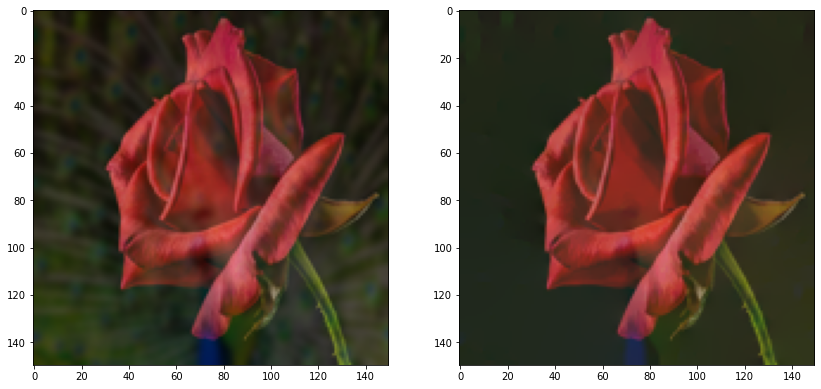

In [ ]:
T_img = Image.fromarray((T_img * 255).astype(np.uint8))

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1, 2, 1)
plt.imshow(Image.fromarray(img))

ax = plt.subplot(1, 2, 2)
plt.imshow(T_img)

In [ ]:
#@title Optimization using Adam, worse than standard GD
class AdamOptimizer:
    def __init__(self, weights, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0
        self.theta = weights

    def backward_pass(self, gradient):
        self.t = self.t + 1
        self.m = self.beta1*self.m + (1 - self.beta1)*gradient
        self.v = self.beta2*self.v + (1 - self.beta2)*(gradient**2)
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        self.theta = self.theta - self.alpha*(m_hat/(np.sqrt(v_hat) - self.epsilon))
        return self.theta

thresh=0.033
eps = 1e-8
max_iters = 2000
print_every = 100
img_norm = img / 255
T_var = img_norm.copy()

# precomputing
div_dh_gradY = np.zeros_like(img_norm)
for ch_idx in range(img_norm.shape[-1]):
    div_dh_gradY[:, :, ch_idx] = div_thresh_grad(img_norm[:, :, ch_idx], thresh)

precomputed = div_dh_gradY.copy()
# Adam took 26 mins (2k iters) to reach cost 1.4047 with precomputed=None
obj_val_init = objective_fn(T_var, img_norm, thresh, eps, precomputed)
obj_val_best = obj_val_init
T_best = T_var.copy()
gradient_T_prev = np.zeros_like(T_var)
print('iter: %3d, cost: %.4f'%(0, obj_val_init))

optimizer = AdamOptimizer(T_var, alpha=5e-4)

for iter_idx in range(max_iters):
    gradient_T_curr = grad_T(T_var, img_norm, thresh, eps, precomputed)
    T_var = optimizer.backward_pass(gradient_T_curr)
    obj_val_curr = objective_fn(T_var, img_norm, thresh, eps, precomputed)
    if (iter_idx + 1) % print_every == 0:
        print('iter: %3d, cost: %.4f'%(iter_idx+1, obj_val_curr))
    if obj_val_curr < obj_val_best:
        obj_val_best = obj_val_curr
        T_best = T_var.copy()
    else:
        print('cost increased')

T_img = Image.fromarray((T_best * 255).astype(np.uint8))

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1, 2, 1)
plt.imshow(Image.fromarray(img))

ax = plt.subplot(1, 2, 2)
plt.imshow(T_img)